#**Troll checker for social media Ipynb file**


This project aims to develop a machine learning model that can detect hate speech, offensive language, and neutral content from user comments on social media platforms. Additionally, the project explores rephrasing techniques to convert harmful comments into positive or neutral language.

Note: Carefully read the comments and implement the code

Data analysis phase:

In [ ]:
#download all required libraries
!pip install google-generativeai
!pip install datasets
!pip install transformers
!pip install torch
!pip install nltk
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

In [ ]:
#importing all required libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
from datasets import Dataset, load_metric
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from google.colab import userdata

In [ ]:
df = pd.read_csv(labeled_data.csv) #Read CSV

print(df.head())

df = df.drop(columns=['count', 'Unnamed: 0', 'class']) #remove unnecessary columns

print(df.head()) #Inspect the dataset
print(df.info())


In [ ]:
nltk.download('stopwords') # Download required NLTK data

#Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\brt\b', '', text)  #Remove RT(Replied to)
    text = re.sub(r'[^a-z\s]', '', text)  #Remove punctuation and numbers
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])  #Remove stopwords
    return text

#Apply preprocessing
df['cleaned_comment'] = df['tweet'].apply(preprocess_text)

#Inspect the cleaned comments
print(df[['tweet', 'cleaned_comment']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                     cleaned_comment  
0  mayasolovely woman shouldnt complain cleaning ...  
1  mleew boy dats coldtyga dwn bad cuffin dat hoe...  
2  urkindofbrand dawg sbabylife ever fuck bitch s...  
3              cganderson vivabased look like tranny  
4  shenikaroberts shit hear might true might fake...  


Logistic regression for training on unseen data:

In [ ]:
#TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_comment'])


In [ ]:
y = df[['hate_speech', 'offensive_language', 'neither']].idxmax(axis=1) #lebeling each class

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


                    precision    recall  f1-score   support

       hate_speech       0.52      0.16      0.24       290
           neither       0.83      0.83      0.83       835
offensive_language       0.91      0.96      0.94      3832

          accuracy                           0.89      4957
         macro avg       0.75      0.65      0.67      4957
      weighted avg       0.88      0.89      0.88      4957



BERT uncased classification model:


In [ ]:
df['label'] = df[['hate_speech', 'offensive_language', 'neither']].idxmax(axis=1) #Combine labels into a single column
df['label'] = df['label'].map({'hate_speech': 0, 'offensive_language': 1, 'neither': 2})

#Drop the individual label columns
df = df.drop(columns=['hate_speech', 'offensive_language', 'neither'])


print("Combined Labels Dataset:")
print(df.head())

Combined Labels Dataset:
                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                     cleaned_comment  label  
0  mayasolovely woman shouldnt complain cleaning ...      2  
1  mleew boy dats coldtyga dwn bad cuffin dat hoe...      1  
2  urkindofbrand dawg sbabylife ever fuck bitch s...      1  
3              cganderson vivabased look like tranny      1  
4  shenikaroberts shit hear might true might fake...      1  


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #Load the pre-trained BERT tokenizer

dataset = Dataset.from_pandas(df)

#Define a function to tokenize the text
def tokenize_function(examples):
    return tokenizer(examples['cleaned_comment'], padding="max_length", truncation=True)

#Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

#Set the format for PyTorch
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

#Split the dataset into training and test sets
train_dataset = tokenized_dataset.shuffle(seed=42).select(range(int(0.8 * len(tokenized_dataset))))
test_dataset = tokenized_dataset.shuffle(seed=42).select(range(int(0.8 * len(tokenized_dataset)), len(tokenized_dataset)))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/24783 [00:00<?, ? examples/s]

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)


In [ ]:
#Model training

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3) #Define model

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)
#Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

#Train the model
trainer.train()

#Evaluate the model
trainer.evaluate()

trainer.save_model('./results/final_model')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.545300,0.319321
2,0.482900,0.314121
3,0.197400,0.334059


In [ ]:
trainer.save_model('./results/final_model') #save the model

In [ ]:
predictions = trainer.predict(test_dataset)

#Compute metrics using predictions
metrics = compute_metrics(predictions)
print(metrics)


{'accuracy': 0.9114383699818439}


In [ ]:
model_path = './results/final_model' #Loading the path from local device

model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)

#Define evaluation arguments
eval_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=8,
    logging_dir='./logs',
)


#Split the dataset into training and test sets
test_dataset = tokenized_dataset.shuffle(seed=42).select(range(int(0.8 * len(tokenized_dataset)), len(tokenized_dataset)))

#Initialize Trainer for evaluation
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=test_dataset,
)

#Evaluate the model to get predictions
predictions = trainer.predict(test_dataset)

#Extract predictions and labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("Predictions:", preds[:10])
print("Labels:", labels[:10])


Predictions: [1 1 1 2 2 0 1 1 1 1]
Labels: [1 1 1 2 2 0 1 1 1 1]


The repository for precision contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/precision.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for recall contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/recall.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
Accuracy: 0.9114383699818439
Precision: 0.9015670505359209
Recall: 0.9114383699818439
F1 Score: 0.9049397417553929


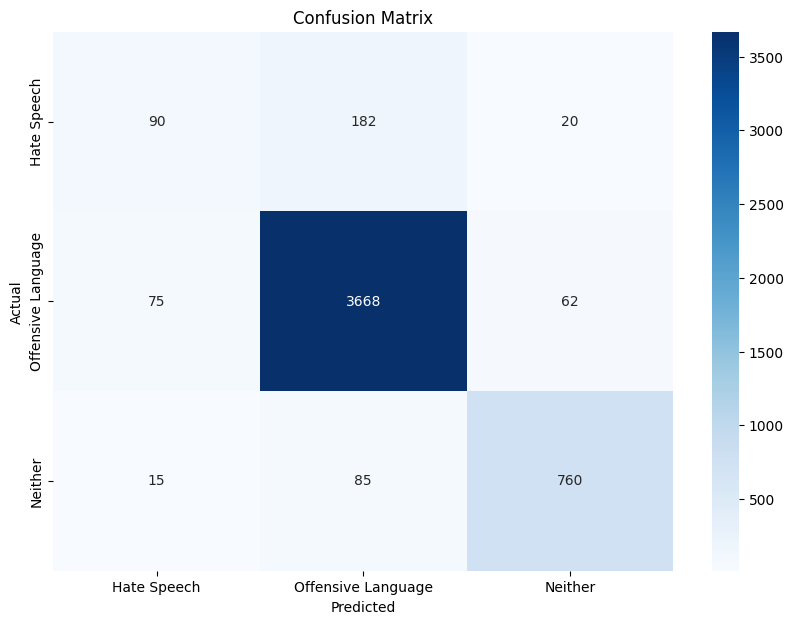

                    precision    recall  f1-score   support

       Hate Speech       0.50      0.31      0.38       292
Offensive Language       0.93      0.96      0.95      3805
           Neither       0.90      0.88      0.89       860

          accuracy                           0.91      4957
         macro avg       0.78      0.72      0.74      4957
      weighted avg       0.90      0.91      0.90      4957



In [ ]:
#Print metrics and visualise confusion matrix
#Load the metrics
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

#Compute metrics
accuracy = accuracy_metric.compute(predictions=preds, references=labels)
precision = precision_metric.compute(predictions=preds, references=labels, average="weighted")
recall = recall_metric.compute(predictions=preds, references=labels, average="weighted")
f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")

#Print metrics
print(f"Accuracy: {accuracy['accuracy']}")
print(f"Precision: {precision['precision']}")
print(f"Recall: {recall['recall']}")
print(f"F1 Score: {f1['f1']}")

#Compute the confusion matrix
cm = confusion_matrix(labels, preds)

#Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive Language', 'Neither'], yticklabels=['Hate Speech', 'Offensive Language', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Print classification report
print(classification_report(labels, preds, target_names=['Hate Speech', 'Offensive Language', 'Neither']))


Model testing by input comment:


In [ ]:
# Load the model and tokenizer
model_path = './results/final_model'
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def predict_comment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    return prediction

# Map prediction to label
label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}

def classify_comment(text):
    prediction = predict_comment(text)
    return label_map[prediction]
# Test comments
comments = [
    "I dont like black people"
]

# Classify each comment
for comment in comments:
    classification = classify_comment(comment)
    print(f"Comment: {comment}\nClassification: {classification}\n")


Comment: I dont like black people
Classification: Neither



Twitter Roberta classification model:

In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

#Tokenize the dataset with padding
def tokenize_function(examples):
    return tokenizer(examples['cleaned_comment'], padding="max_length", truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/24783 [00:00<?, ? examples/s]

In [ ]:
#model training
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

#Split the dataset into training and test sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

#Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        "accuracy": (p.predictions.argmax(-1) == p.label_ids).astype(np.float32).mean().item()
    }
)

#Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model('./results/final_model')
!zip -r results.zip ./results

# Download the zipped results folder
from google.colab import files
files.download('results.zip')


In [ ]:
# Save the fine-tuned model
output_dir = '/content/drive/MyDrive/results/final_model'
trainer.save_model(output_dir)

# Save the tokenizer as well
tokenizer.save_pretrained(output_dir)


('/content/drive/MyDrive/results/final_model/tokenizer_config.json',
 '/content/drive/MyDrive/results/final_model/special_tokens_map.json',
 '/content/drive/MyDrive/results/final_model/vocab.json',
 '/content/drive/MyDrive/results/final_model/merges.txt',
 '/content/drive/MyDrive/results/final_model/added_tokens.json',
 '/content/drive/MyDrive/results/final_model/tokenizer.json')

In [ ]:
model.save_pretrained(output_dir)

In [ ]:
#model evaluation
model_path = '/content/drive/MyDrive/results/final_model'

model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)

eval_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    evaluation_strategy="no",
    report_to=None,
    disable_tqdm=True,
)

trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=test_dataset,
)

predictions = trainer.predict(tokenized_test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

accuracy = np.mean(preds == labels)

print(f"Accuracy: {accuracy:.4f}")
print("Predictions:", preds[:10])
print("Labels:", labels[:10])


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Accuracy: 0.9746
Predictions: [1 1 2 1 1 1 1 1 1 1]
Labels: [1 1 2 1 1 1 1 1 1 1]


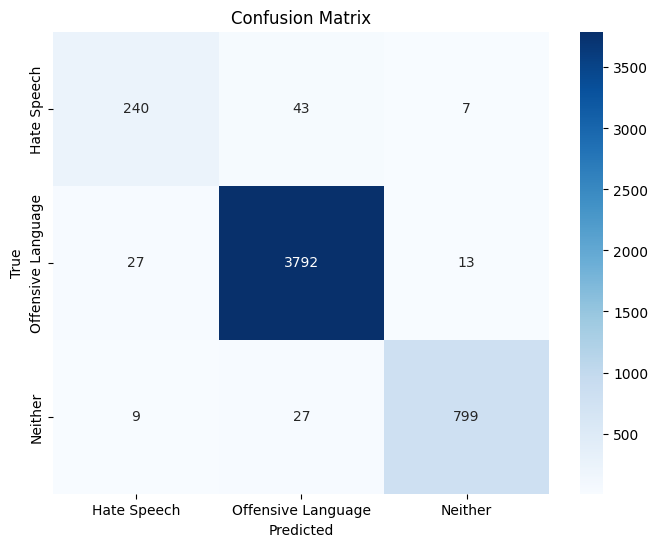

Classification Report:
                     precision    recall  f1-score   support

       Hate Speech       0.87      0.83      0.85       290
Offensive Language       0.98      0.99      0.99      3832
           Neither       0.98      0.96      0.97       835

          accuracy                           0.97      4957
         macro avg       0.94      0.92      0.93      4957
      weighted avg       0.97      0.97      0.97      4957



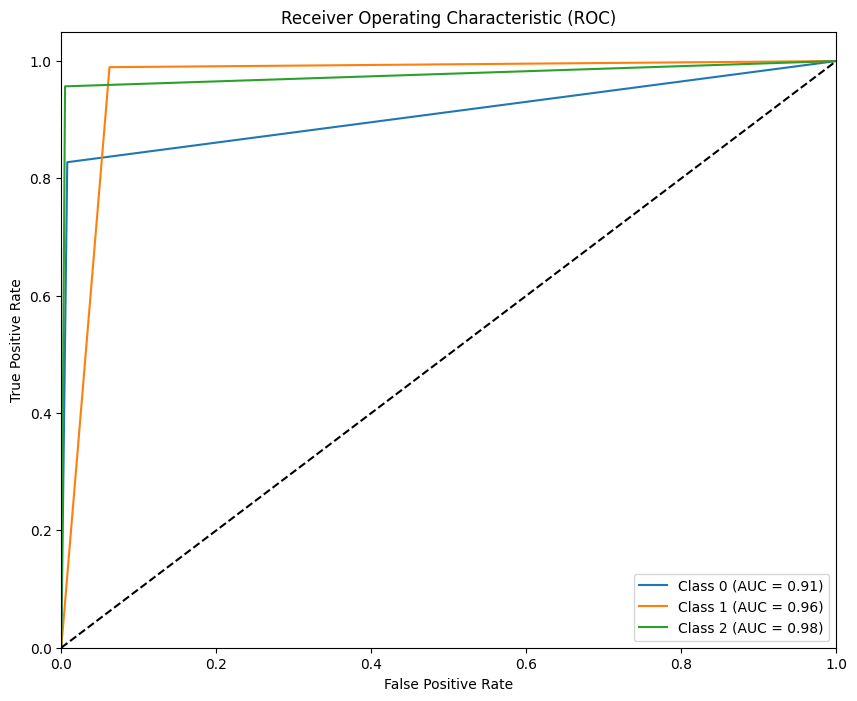

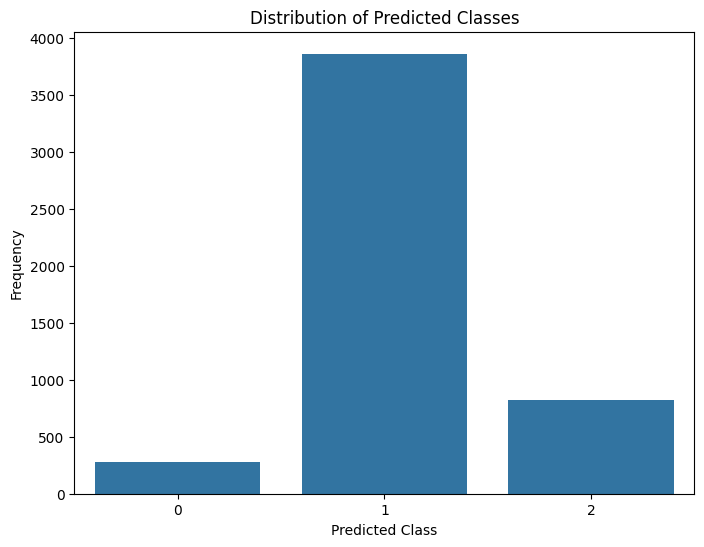

Misclassified Examples (Total: 126):
Original Comment: iamshady thats even real word must hit blunt started making shit nigger ass lol
True Label: 0 | Predicted Label: 1

Original Comment: nah overgt people dont tell artists thats defies definition trying show youpeople retards game
True Label: 2 | Predicted Label: 0

Original Comment: geokthree literally told blacksins face trash shop hooping
True Label: 2 | Predicted Label: 1

Original Comment: rockprincess go fight idf progressive trash hate much dont guts istandwithisr
True Label: 2 | Predicted Label: 0

Original Comment: bankheist youre retard shawnacarr
True Label: 0 | Predicted Label: 1



In [ ]:
#1. Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive Language', 'Neither'], yticklabels=['Hate Speech', 'Offensive Language', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#2. Classification Report
report = classification_report(labels, preds, target_names=['Hate Speech', 'Offensive Language', 'Neither'])
print("Classification Report:\n", report)

#3. ROC Curve and AUC Score
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(np.array(labels) == i, np.array(preds) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 4.Distribution of Predicted Classes
plt.figure(figsize=(8, 6))
sns.countplot(x=preds, order=[0, 1, 2])
plt.title('Distribution of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Frequency')
plt.show()

# 5.Misclassified Examples
misclassified_indices = np.where(preds != labels)[0]
print(f"Misclassified Examples (Total: {len(misclassified_indices)}):")
for i in misclassified_indices[:5]:  # Show first 5 misclassified examples
    print(f"Original Comment: {test_df.iloc[i]['cleaned_comment']}")
    print(f"True Label: {labels[i]} | Predicted Label: {preds[i]}\n")



testing model by input comment:

In [ ]:
# Load the saved model and tokenizer
model_path = '/content/drive/MyDrive/results/final_model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

def predict_comment(text):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    return prediction

#Map prediction to label
label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}

# Function to classify comment
def classify_comment(text):
    prediction = predict_comment(text)
    return label_map[prediction]

comments = [
    "bitch"
]
for comment in comments:
    classification = classify_comment(comment)
    print(f"Comment: {comment}\nClassification: {classification}\n")


Comment: bitch
Classification: Offensive Language



Rephrasing large language model: Gemini 1.5 flash

In [ ]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')  #Load your own API key here from Google cloud
genai.configure(api_key=GOOGLE_API_KEY)


Safety settings for rephrasing model mechanism

In [ ]:
safe = [
    {
        "category": "HARM_CATEGORY_HARASSMENT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_HATE_SPEECH",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
        "threshold": "BLOCK_NONE",
    },
    {
        "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
        "threshold": "BLOCK_NONE",
    },
]

In [ ]:
"""
Install the Google AI Python SDK

$ pip install google-generativeai

See the getting started guide for more information:
https://ai.google.dev/gemini-api/docs/get-started/python
"""

import os

import google.generativeai as genai
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
#If running locally use the following commented code: Google_API_KEY = "Your api key here"

genai.configure(api_key=GOOGLE_API_KEY)
# Create the model
generation_config = {
  "temperature": 0.65,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  generation_config=generation_config,

  # See https://ai.google.dev/gemini-api/docs/safety-settings
  system_instruction="Rewrite the following hate speech comment into a positive comment, keeping the sentence structure the same. For example, I don't like black people' should be rewritten as Black people are great",
)

chat_session = model.start_chat(
  history=[
    {
      "role": "user",
      "parts": [
        "You are the uggliest person ever",
      ],
    },
    {
      "role": "model",
      "parts": [
        "You have a unique and interesting appearance. \n",
      ],
    },
  ]
)

response = chat_session.send_message("you are a looser")

print(response.text)

You are a strong and resilient individual. 



# Below are some of the LLMs tested for rephrasing but failed:

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

#Load the GPT-2 model and tokenizer
gpt2_model_id = "gpt2"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_id)
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_id)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
def rephrase_with_gpt2(text):
    prompt = f"Rephrase the following negative comment into a positive one: {text}"
    inputs = gpt2_tokenizer.encode(prompt, return_tensors='pt', max_length=512, truncation=True)
    outputs = gpt2_model.generate(inputs, max_length=150, num_return_sequences=1, pad_token_id=gpt2_tokenizer.eos_token)
    return gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
classification_model_path = './results/final_model'
classification_model = AutoModelForSequenceClassification.from_pretrained(classification_model_path)
classification_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Load the GPT-2 model and tokenizer for rephrasing
gpt2_model_id = "gpt2"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_id)
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_id)

def predict_comment(text):
    inputs = classification_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = classification_model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    return prediction

label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}

def classify_comment(text):
    prediction = predict_comment(text)
    return label_map[prediction]

def rephrase_with_gpt2(text):
    prompt = f"Rephrase the following negative comment into a positive one: {text}"
    inputs = gpt2_tokenizer.encode(prompt, return_tensors='pt', max_length=512, truncation=True)
    outputs = gpt2_model.generate(inputs, max_length=150, num_return_sequences=1, pad_token_id=gpt2_tokenizer.eos_token_id)
    return gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)

def process_comment(text):
    classification = classify_comment(text)
    if classification == "Hate Speech":
        rephrased_comment = rephrase_with_gpt2(text)
        return f"Original: {text}\nRephrased: {rephrased_comment}\n"
    elif classification == "Offensive Language":
        return f"Original: {text}\nFlagged as Offensive\n"
    else:
        return f"Original: {text}\nClassification: {classification}\n"

# Example comments for testing
comments = [
    "I don't like black people.",
    "You are such an idiot!",
    "I love this book, it's amazing!",
    "You are a wonderful person!",
    "Go back to where you came from!",
    "This is the best day ever!",
    "Shut up, no one cares about you.",
    "All people like you should be banned."
]

# Test the process_comment function
for comment in comments:
    result = process_comment(comment)
    print(result)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Original: I don't like black people.
Rephrased: Rephrase the following negative comment into a positive one: I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black people. I don't like black

Original: You are such an idiot!
Rephrased: Rephrase the following negative comment into a positive one: You are such an idiot!

I'm not sure what you're talking about. I'm not sure what you're talking about.

I'm not sure what you're talking about.

I'm not sure what you're talking about.

I'm not sure what you're talking about.

I'm not sure what you're 

In [ ]:
#Load the Dolly 15k dataset
dataset = load_dataset("databricks/databricks-dolly-15k")
df = pd.DataFrame(dataset['train'])

#Extract only the 'instruction' and 'response' fields
df = df[['instruction', 'response']]

#Rename the columns to match expected format
df.rename(columns={'instruction': 'input_text', 'response': 'target_text'}, inplace=True)

# Split the dataset into training and validation sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Convert the DataFrames back to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

from transformers import AutoModelForCausalLM

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

def tokenize_function(examples):
    model_inputs = tokenizer(examples['input_text'], max_length=512, truncation=True, padding='max_length')
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['target_text'], max_length=512, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Tokenize the split datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-5,
    num_train_epochs=3,
    output_dir="./results",
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")


trainer.save_model('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name_or_path = './fine_tuned_model'
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelForCausalLM.from_pretrained(model_name_or_path)

# Define the rephrasing function
def rephrase_hate_speech(hate_speech):
    prompt = f"Rephrase the following hateful statement into a neutral and positive message: {hate_speech}"
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(inputs, max_length=150, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
    rephrased_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return rephrased_text

# Test the model with sample hate speech prompts
test_prompts = [
    "You are such an idiot!",
    "Go back to where you came from!",
    "All people like you should be banned.",
    "You are a complete failure.",
    "I don't like black people."
]

for prompt in test_prompts:
    rephrased = rephrase_hate_speech(prompt)
    print(f"Original: {prompt}")
    print(f"Rephrased: {rephrased}\n")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Original: You are such an idiot!
Rephrased: Rephrase the following hateful statement into a neutral and positive message: You are such an idiot!

Original: Go back to where you came from!
Rephrased: Rephrase the following hateful statement into a neutral and positive message: Go back to where you came from!

Original: All people like you should be banned.
Rephrased: Rephrase the following hateful statement into a neutral and positive message: All people like you should be banned.

Original: You are a complete failure.
Rephrased: Rephrase the following hateful statement into a neutral and positive message: You are a complete failure.

Original: I don't like black people.
Rephrased: Rephrase the following hateful statement into a neutral and positive message: I don't like black people.



In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("allenai/tk-instruct-3b-def")
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/tk-instruct-3b-def")

def rephrase_hate_speech(hate_speech):
    instruction = "Rephrase the following statement to be neutral and positive: "
    input_text = instruction + hate_speech
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Generate output from the model
    output_ids = model.generate(input_ids, max_length=150, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

    # Decode the output
    rephrased_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return rephrased_text

# Test the function with sample hate speech prompts
test_prompts = [
    "You are such an idiot!",
    "Go back to where you came from!",
    "All people like you should be banned.",
    "You are a complete failure.",
    "I don't like black people."
]

for prompt in test_prompts:
    rephrased = rephrase_hate_speech(prompt)
    print(f"Original: {prompt}")
    print(f"Rephrased: {rephrased}\n")


tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Original: You are such an idiot!
Rephrased: You are such a jerk!

Original: Go back to where you came from!
Rephrased: Go back to where you came from!

Original: All people like you should be banned.
Rephrased: You should be banned from the internet.

Original: You are a complete failure.
Rephrased: You are a failure.

Original: I don't like black people.
Rephrased: I don't like the color of their skin.



In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the T5 tokenizer and model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def rephrase_hate_speech(hate_speech):
    instruction = "Rephrase the following statement to be neutral and positive: "
    input_text = instruction + hate_speech
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Generate output from the model
    output_ids = model.generate(input_ids, max_length=150, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

    # Decode the output
    rephrased_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return rephrased_text

# Test the function with sample hate speech prompts
test_prompts = [
    "You are such an idiot!",
    "Go back to where you came from!",
    "All people like you should be banned.",
    "You are a complete failure.",
    "I don't like black people."
]

for prompt in test_prompts:
    rephrased = rephrase_hate_speech(prompt)
    print(f"Original: {prompt}")
    print(f"Rephrased: {rephrased}\n")


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Original: You are such an idiot!
Rephrased: Rephrase the following statement to be neutral and positive: You are such an idiot!

Original: Go back to where you came from!
Rephrased: Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu-Neu

Original: All people like you should be banned.
Rephrased: Rephrase the following statement to be neutral and positive: All people like you should be banned.

Original: You are a complete failure.
Rephrased: Rephrase the following statement to be neutral and positive: You are a complete failure.

Original: I don't like black people.
Rephrased: Rephrase the following statement to be neutral and positive: I don't like black people.

